# Python Basecamp

### Karthikeyan Sankaran, 17th June, 2018

### End to End ML Pipeline [BigMart Sales]: Notebook 2 - Feature Engineering

In [99]:
# Import relevant packages & functions

import pandas as pd
import numpy as np
import os
from scipy import stats
from scipy.stats import mode

import missingno as msno
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer

from sklearn.decomposition import PCA, NMF

from sklearn.pipeline import Pipeline,FeatureUnion
from generic_transformers import *
from utility_functions import *

import warnings
warnings.filterwarnings('ignore')

from patsylearn import *
from patsylearn import PatsyTransformer

from category_encoders import (BackwardDifferenceEncoder,BinaryEncoder,HashingEncoder,HelmertEncoder,
                               OneHotEncoder,OrdinalEncoder,SumEncoder,PolynomialEncoder)

In [100]:
DATA_FOLDER = '../datasets/'
train_df      = pd.read_csv(os.path.join(DATA_FOLDER, 'BigMartSales-Training.csv'))
test_df       = pd.read_csv(os.path.join(DATA_FOLDER, 'BigMartSales-Testing.csv'))

In [101]:
## Peek into the dataset
train_df.info()
#train_df.head()
#train_df.columns
#unique_col_values(train_df)
#train_df['Item_Fat_Content'].value_counts()
#train_df['Item_Fat_Content'].unique()
#train_df.describe().T
#train_df.columns.tolist()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
Item_Identifier              8523 non-null object
Item_Weight                  7060 non-null float64
Item_Fat_Content             8523 non-null object
Item_Visibility              8523 non-null float64
Item_Type                    8523 non-null object
Item_MRP                     8523 non-null float64
Outlet_Identifier            8523 non-null object
Outlet_Establishment_Year    8523 non-null int64
Outlet_Size                  6113 non-null object
Outlet_Location_Type         8523 non-null object
Outlet_Type                  8523 non-null object
Item_Outlet_Sales            8523 non-null float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.1+ KB


In [102]:
train_df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [103]:
raw_features = train_df.columns
print(raw_features)
print(len(raw_features))

Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type', 'Item_Outlet_Sales'],
      dtype='object')
12


In [104]:
train_df['source']='train'
test_df['source']='test'
data = pd.concat([train_df, test_df],ignore_index=True)
print (train_df.shape, test_df.shape, data.shape)

(8523, 13) (5681, 12) (14204, 13)


## Feature Engineering

** Set 0: Setting up the dataset **

** Set 0.1: Setting the target **

In [105]:
target_df = pd.DataFrame()
target_df['Item_Outlet_Sales'] = train_df['Item_Outlet_Sales']
target_df['Unit_Sales'] = np.round(train_df['Item_Outlet_Sales'] / train_df['Item_MRP'])

In [106]:
target_pipe = Pipeline([
            ('log',DFFunctionTransformer(np.log1p)),
         ])

target_cols = target_pipe.fit_transform(target_df)
target_cols.rename(columns=lambda x: x + '_log', inplace=True)

In [107]:
target_df = pd.concat([target_df,target_cols],axis=1)

In [108]:
target_df.head()

,Item_Outlet_Sales,Unit_Sales,Item_Outlet_Sales_log,Unit_Sales_log
0,3735.1380,15.0,8.225808,2.772589
1,443.4228,9.0,6.096776,2.302585
2,2097.2700,15.0,7.648868,2.772589
3,732.3800,4.0,6.597664,1.609438
4,994.7052,18.0,6.903451,2.944439


In [109]:
target = "Item_Outlet_Sales"

** Set 0.2: Setting the features set **

In [110]:
# Code to check for i) duplicate rows, ii) duplicate columns, iii) Totally useless row / columns that can be removed

** Features set 1: Missing Values **

In [111]:
missing_df = pd.DataFrame()

In [112]:
print(data.apply(num_missing, axis=0))

Item_Fat_Content                0
Item_Identifier                 0
Item_MRP                        0
Item_Outlet_Sales            5681
Item_Type                       0
Item_Visibility                 0
Item_Weight                  2439
Outlet_Establishment_Year       0
Outlet_Identifier               0
Outlet_Location_Type            0
Outlet_Size                  4016
Outlet_Type                     0
source                          0
dtype: int64


In [113]:
# Missing Values
#msno.matrix(data, labels=True)
#msno.heatmap(data)
#msno.dendrogram(data)

In [114]:
missing_cols = ['Item_Weight','Outlet_Size','Item_Visibility']

In [115]:
# 1 - Handling missing data - Impute and/or create new features
missing_df.loc[:,'Outlet_Size_Imputed'] = data.loc[:,'Outlet_Size']
missing_df.loc[:,'Outlet_Size_FillNA'] = data.loc[:,'Outlet_Size']
missing_df.loc[:,'Outlet_Size_NaN'] = 'Not_Missing'

#Determing the mode for each
outlet_size_mode = data.pivot_table(values='Outlet_Size', columns='Outlet_Type',aggfunc=(lambda x:mode(x.dropna()).mode[0]) )

outlet_size_dict = {'Grocery Store':'Small','Supermarket Type1':'Small',
                    'Supermarket Type2':'Medium','Supermarket Type3':'Medium'}


#Get a boolean variable specifying missing Outlet values
miss_bool = data['Outlet_Size'].isnull() 

#Impute data and check #missing values before and after imputation to confirm
print ('\nOrignal #missing: %d'% sum(miss_bool))
missing_df.loc[miss_bool,'Outlet_Size_Imputed'] = data.loc[miss_bool,'Outlet_Type'].map(outlet_size_dict)
missing_df.loc[miss_bool,'Outlet_Size_NaN'] = 'Missing'
missing_df['Outlet_Size_FillNA'].fillna('Missing',inplace=True)
print (sum(missing_df['Outlet_Size_Imputed'].isnull()))


Orignal #missing: 4016
0


In [116]:
# 2 - Handling missing data - Impute and/or create new features
# Item Weight
missing_df.loc[:,'Item_Weight_Imputed'] = data.loc[:,'Item_Weight']
missing_df.loc[:,'Item_Weight_FillNA'] = data.loc[:,'Item_Weight']
missing_df.loc[:,'Item_Weight_NaN'] = 'Not_Missing'

item_avg_wt = data.groupby('Item_Identifier')['Item_Weight'].mean()
#Get a boolean variable specifying missing Item_Weight values
miss_bool = data['Item_Weight'].isnull() 

#Impute data and check #missing values before and after imputation to confirm
print ('Original #missing: %d'% sum(miss_bool))
missing_df.loc[miss_bool,'Item_Weight_Imputed'] = data.loc[miss_bool,'Item_Identifier'].map(item_avg_wt)
missing_df.loc[miss_bool,'Item_Weight_NaN'] = 'Missing'
missing_df['Item_Weight_FillNA'].fillna(-999,inplace=True)
print ('Final #missing: %d'% sum(missing_df['Item_Weight_Imputed'].isnull()))

Original #missing: 2439
Final #missing: 0


In [117]:
# 3 - Handling missing data (Values are present but are not logical. Ex: Item Visibility=0)
# Item_Visibility
if 1==1:
    missing_df.loc[:,'Item_Visibility_Imputed'] = data.loc[:,'Item_Visibility']
    missing_df.loc[:,'Item_Visibility_FillNA'] = data.loc[:,'Item_Visibility']
    missing_df.loc[:,'Item_Visibility_NaN'] = 'Not_Missing'
    
    #Determine average visibility of a product
    visibility_avg = data.groupby('Item_Identifier')['Item_Visibility'].mean()    

    #Impute 0 values with mean visibility of that product:
    miss_bool = (data['Item_Visibility'] == 0)

    print ('Number of 0 values initially: %d'%sum(miss_bool))
    missing_df.loc[miss_bool,'Item_Visibility_Imputed'] = data.loc[miss_bool,'Item_Identifier'].map(visibility_avg)
    missing_df.loc[miss_bool,'Item_Visibility_NaN'] = 'Missing'
    missing_df['Item_Visibility_FillNA'].fillna(-999,inplace=True)   
    print ('Number of 0 values after modification: %d'%sum(missing_df['Item_Visibility_Imputed'] == 0))

Number of 0 values initially: 879
Number of 0 values after modification: 0


In [118]:
missing_df.head()

,Outlet_Size_Imputed,Outlet_Size_FillNA,Outlet_Size_NaN,Item_Weight_Imputed,Item_Weight_FillNA,Item_Weight_NaN,Item_Visibility_Imputed,Item_Visibility_FillNA,Item_Visibility_NaN
0,Medium,Medium,Not_Missing,9.30,9.30,Not_Missing,0.016047,0.016047,Not_Missing
1,Medium,Medium,Not_Missing,5.92,5.92,Not_Missing,0.019278,0.019278,Not_Missing
2,Medium,Medium,Not_Missing,17.50,17.50,Not_Missing,0.016760,0.016760,Not_Missing
3,Small,Missing,Missing,19.20,19.20,Not_Missing,0.017834,0.000000,Missing
4,High,High,Not_Missing,8.93,8.93,Not_Missing,0.009780,0.000000,Missing


In [119]:
data = pd.concat([data,missing_df],axis=1)

** Feature set 2: Domain or Data based features **

In [120]:
new_features_df = pd.DataFrame()

In [121]:
# 1 - Creating new columns from categorical variables
# Item Fat Content
new_features_df['Item_Fat_Content_modified'] = data['Item_Fat_Content'].replace({'LF':'Low Fat',
                                                             'reg':'Regular',
                                                             'low fat':'Low Fat'})
# Item Type Combined
new_features_df['Item_Type_Combined'] = data['Item_Identifier'].apply(lambda x: x[0:2])

#Mark non-consumables as separate category in low_fat:
new_features_df.loc[new_features_df['Item_Type_Combined']=="NC",'Item_Fat_Content_modified'] = "Non-Edible"

In [122]:
# 2 - Creating new columns from numerical variables
new_features_df['Outlet_Years'] = 2013 - data['Outlet_Establishment_Year']

In [123]:
# 3 - Creating categories for Numerical variables
# Item MRP
price_cat = ['Very_Low_Price', 'Low_Price',
             'Moderate_Price','High_Price',
             'Very_High_Price']

new_features_df['PriceLevels'] = pd.qcut(data['Item_MRP'],5, price_cat)
new_features_df['PriceLevels'] = new_features_df['PriceLevels'].astype(object)

# Item Weight
weight_cat = ['Very_Low_Weight', 'Low_Weight',
             'Moderate_Weight','High_Weight',
             'Very_High_Weight']

new_features_df['WeightLevels'] = pd.qcut(data['Item_Weight'],5, weight_cat)
new_features_df['WeightLevels'] = new_features_df['WeightLevels'].astype(object)

# Item Visibility
visibility_cat = ['Low_Visibility','Moderate_Visibility','High_Visibility']

new_features_df['VisibilityLevels'] = pd.qcut(data['Item_Visibility'],3, visibility_cat)
new_features_df['VisibilityLevels'] = new_features_df['VisibilityLevels'].astype(object)

In [124]:
# 4 - Handling Outliers - Clipping numerical values

# Item_MRP
cols_for_clipping = ['Item_MRP']

for col in cols_for_clipping:
    new_col = col + '_clipped'
    new_features_df[new_col] = data[col].values

    llimit = np.nanpercentile(data[col].values, 1)  #Here 1% is the threshold but that number can be changed
    ulimit = np.nanpercentile(data[col].values, 99) #Here 99% is the threshold but that number can be changed
    new_features_df.loc[new_features_df[new_col] < llimit,[new_col]] = llimit
    new_features_df.loc[new_features_df[new_col] > ulimit,[new_col]] = ulimit

In [125]:
new_features_df.head()

,Item_Fat_Content_modified,Item_Type_Combined,Outlet_Years,PriceLevels,WeightLevels,VisibilityLevels,Item_MRP_clipped
0,Low Fat,FD,14,Very_High_Price,Low_Weight,Low_Visibility,249.8092
1,Regular,DR,4,Very_Low_Price,Very_Low_Weight,Low_Visibility,48.2692
2,Low Fat,FD,14,Moderate_Price,High_Weight,Low_Visibility,141.6180
3,Regular,FD,15,High_Price,Very_High_Weight,Low_Visibility,182.0950
4,Non-Edible,NC,26,Very_Low_Price,Low_Weight,Low_Visibility,53.8614


In [126]:
data = pd.concat([data,new_features_df],axis=1)

** Feature Set 3: Date Features **

In [127]:
# Can use the Transformer - DateTimeFeatures (in generictransformers.py)
# 1. Time Moments in a period
if 1==0:
    date_df = pd.DataFrame()
    date_df['date'] = (pd.to_datetime(data["datetime"], format="%Y-%m-%d"))
    
    date_df["DayOfMonth"] = date_df['date'].apply(lambda x: x.day)
    date_df["Month"] = date_df['date'].apply(lambda x: x.month)
    date_df["Year"] = date_df['date'].apply(lambda x: x.year)
    date_df["WeekDay"] = date_df['date'].apply(lambda x: x.weekday())
    date_df["WeekNo"] = date_df['date'].apply(lambda x: x.isocalendar()[1])
    date_df["DayOfYear"] = date_df['date'].apply(lambda x: x.timetuple().tm_yday)
    date_df["DayCount"] = date_df['date'].apply(lambda x: x.toordinal())
    date_df["Hour"] = date_df['date'].apply(lambda x: x.hour)

# 2. Date features based on events - Can be row or column based (Ex: Number of days since a particular event)
if 1==0:
    pass

# 3. Lag based features (especially important in time series problems)
if 1==0:
    #dfx= time_series_to_supervised(df, n_lag= 1, n_fut= 2, dropnan= False, selLag= ['xa'], selFut=['rslt'])
    pass

# 4. TSFresh created features
if 1==0:
    # Use tsfresh package
    pass

if 1==0:
    data = pd.concat([data,date_df],axis=1)

** Features Set 4: Text Based Features **

In [128]:
if 1==0:
    text_df = pd.DataFrame()
    data = pd.concat([data,text_df],axis=1)

** Feature Set 5: Interaction Features **

In [129]:
interaction_cols = ['Item_Visibility_Imputed','Item_MRP_clipped','Outlet_Years','Item_Fat_Content_modified',
                    'Item_Type_Combined','Outlet_Identifier','Outlet_Type','Outlet_Location_Type','Outlet_Size_Imputed',
                    'PriceLevels','WeightLevels','VisibilityLevels']

In [130]:
X = data[data['source']=='train'][interaction_cols]
y = target_df[target]

In [131]:
if 1==0:
    XGBInteractions(X,y,"av-bigmart-FI-1.xlsx",type='regression')

In [132]:
interactions_pipe = Pipeline([
            #('extract_features',ExtractColumns(interaction_cols)),
            ('interactions',PatsyTransformer(
                            ("Outlet_Type:Outlet_Years + Outlet_Years*Item_MRP_clipped"),
                            return_type="dataframe"))
            ])

In [133]:
interactions_df=interactions_pipe.fit_transform(data)
interactions_df.rename(columns=lambda x: x.replace('[', ':'), inplace=True)
interactions_df.rename(columns=lambda x: x.replace(']', ':'), inplace=True)

interactions_df.head()

,Outlet_Years,Outlet_Type:T.Supermarket Type1::Outlet_Years,Outlet_Type:T.Supermarket Type2::Outlet_Years,Outlet_Type:T.Supermarket Type3::Outlet_Years,Item_MRP_clipped,Outlet_Years:Item_MRP_clipped
0,14.0,14.0,0.0,0.0,249.8092,3497.3288
1,4.0,0.0,4.0,0.0,48.2692,193.0768
2,14.0,14.0,0.0,0.0,141.6180,1982.6520
3,15.0,0.0,0.0,0.0,182.0950,2731.4250
4,26.0,26.0,0.0,0.0,53.8614,1400.3964


In [134]:
data = pd.concat([data,interactions_df],axis=1)
data = data.loc[:,~data.columns.duplicated()]

** Feature set 6a: Statistical Features - Computed using GroupBy **

In [135]:
if 1==1: 
    data_copy_df = data.copy()
    grouping_cols = ['Item_Identifier','Outlet_Identifier']
    compute_list = [('Item_MRP',np.mean,'avg'),('Item_Outlet_Sales',np.mean,'avg')]
    stats_df = data_copy_df[grouping_cols]
    for type_id in grouping_cols:
        for column_id,aggregator,aggtype in compute_list:
            compute_df = data_copy_df.groupby([type_id])[column_id].aggregate(aggregator).reset_index()
            compute_df.columns = [type_id,type_id+'_'+aggtype+'_'+column_id]

            stats_df = pd.merge(stats_df,compute_df,on=[type_id],how='left')

    stats_df = stats_df.iloc[:,len(grouping_cols):]
    data = pd.concat([data,stats_df],axis=1)

In [136]:
stats_df.head()

,Item_Identifier_avg_Item_MRP,Item_Identifier_avg_Item_Outlet_Sales,Outlet_Identifier_avg_Item_MRP,Outlet_Identifier_avg_Item_Outlet_Sales
0,249.542533,5198.067050,141.163199,2348.354635
1,48.991422,862.211000,141.000899,1995.498739
2,140.088000,1478.076000,141.163199,2348.354635
3,183.350556,3021.067500,141.159742,339.351662
4,54.861400,653.926567,141.128428,2298.995256


** Feature Set 6b: Target Encoding - Regularized **

In [137]:
cols_target_encoding = ['Item_Identifier','Outlet_Identifier']
# target = 'Item_Outlet_Sales' (Set at the beginning of this notebook)

In [138]:
#sales_item_outlet_agg = train_df.groupby(['Item_Identifier','Outlet_Identifier'])['Item_Outlet_Sales'].mean().reset_index(name='sales')
#sales_item_outlet_agg = train_df.groupby(['Item_Identifier','Outlet_Identifier','Outlet_Type'])['Unit_Sales'].mean().reset_index(name='sales')
sales_item_outlet_agg = data[data['source']=='train'].groupby(cols_target_encoding)[target].mean().reset_index(name='sales')

#sort the data
sales_item_outlet_agg.sort_values(cols_target_encoding,inplace=True)

In [139]:
#from itertools import product

# Extract item, outlet combinations for target encoding
grid = [] 

grid = data[data['source']=='train'].loc[:,cols_target_encoding]

In [140]:
train_target_enc_df = pd.merge(grid,sales_item_outlet_agg,how="left",on=cols_target_encoding).fillna(0)
#sort the data
#train_target_enc_df.sort_values(cols_target_encoding,inplace=True)
test_target_enc_df = data[data['source']=='test'][cols_target_encoding].copy()

In [141]:
# Target encoding - No Regularization
if 1==1:
    for col in cols_target_encoding:
        col_mean = train_target_enc_df.groupby(col).sales.mean()
        #col_median = train_target_enc_df.groupby(col).sales.median()
        #col_stdev = train_target_enc_df.groupby(col).sales.std(ddof=0)

        train_target_enc_df[col + '_mean_enc'] = train_target_enc_df[col].map(col_mean)
        #train_target_enc_df[col + '_median_enc'] = train_target_enc_df[col].map(col_median)
        #train_target_enc_df[col + '_stdev_enc'] = train_target_enc_df[col].map(col_stdev)
        
        # Test data
        test_target_enc_df[col + '_mean_enc'] = test_target_enc_df[col].map(col_mean)
        #test_target_enc_df[col + '_median_enc'] = test_target_enc_df[col].map(col_median)
        #test_target_enc_df[col + '_stdev_enc'] = test_target_enc_df[col].map(col_stdev)
    
        if 1==0:
            print(col)
            print("Mean corr: %.2f" %(np.corrcoef(train_target_enc_df['sales'].values, train_target_enc_df[col + '_mean_enc'].values)[0][1]))
            print("Median corr: %.2f" %(np.corrcoef(train_target_enc_df['sales'].values, train_target_enc_df[col + '_median_enc'].values)[0][1]))
            print("Std corr: %.2f" %(np.corrcoef(train_target_enc_df['sales'].values, train_target_enc_df[col + '_stdev_enc'].values)[0][1]))

In [142]:
# Target encoding - K-Fold Regularization

from sklearn.model_selection import KFold
y_tr = train_target_enc_df['sales'].values
kfold = KFold(n_splits=5,shuffle=True,random_state=984)

for train_index, val_index in kfold.split(train_target_enc_df):
    X_tr, X_val = train_target_enc_df.iloc[train_index],train_target_enc_df.iloc[val_index]
    #mean_values_from_tr = X_tr.groupby('Item_Identifier').sales.mean()
    #mean_values_mapped_val = X_val['Item_Identifier'].map(mean_values_from_tr)
    for col in cols_target_encoding:
        mean_col_name = col + '_mean_enc_fold'
        #median_col_name = col + '_median_enc_fold'
        #stdev_col_name = col + '_stdev_enc_fold'
        
        train_target_enc_df[mean_col_name] = np.NAN
        #train_target_enc_df[median_col_name] = np.NAN
        #train_target_enc_df[stdev_col_name] = np.NAN
        
        # Test set
        test_target_enc_df[mean_col_name] = np.NAN
        
        mean_values_mapped_val = X_val[col].map(X_tr.groupby(col).sales.mean())
        #median_values_mapped_val = X_val[col].map(X_tr.groupby(col).sales.median())
        #stdev_values_mapped_val = X_val[col].map(X_tr.groupby(col).sales.std(ddof=0))
    
        train_target_enc_df.loc[train_target_enc_df.index[val_index],mean_col_name] = mean_values_mapped_val
        #train_target_enc_df.loc[train_target_enc_df.index[val_index],median_col_name] = median_values_mapped_val
        #train_target_enc_df.loc[train_target_enc_df.index[val_index],stdev_col_name] = stdev_values_mapped_val
        
        # Test set
        test_target_enc_df.loc[:,mean_col_name] = mean_values_mapped_val
        #test_target_enc_df.loc[:,median_col_name] = median_values_mapped_val
        #test_target_enc_df.loc[:,stdev_col_name] = stdev_values_mapped_val
        
# Fill NaNs
for col in cols_target_encoding:
    mean_col_name = col + '_mean_enc_fold'
    #median_col_name = col + '_median_enc_fold'
    #stdev_col_name = col + '_stdev_enc_fold'
    
    train_target_enc_df.loc[train_target_enc_df[mean_col_name].isnull(),mean_col_name] = train_target_enc_df[col + '_mean_enc']
    #train_target_enc_df.loc[train_target_enc_df[median_col_name].isnull(),median_col_name] = train_target_enc_df[col + '_median_enc']
    #train_target_enc_df.loc[train_target_enc_df[stdev_col_name].isnull(),stdev_col_name] = train_target_enc_df[col + '_stdev_enc']
    
    # Test
    test_target_enc_df.loc[test_target_enc_df[mean_col_name].isnull(),mean_col_name] = test_target_enc_df[col + '_mean_enc']
    #test_target_enc_df.loc[test_target_enc_df[median_col_name].isnull(),median_col_name] = test_target_enc_df[col + '_median_enc']
    #test_target_enc_df.loc[test_target_enc_df[stdev_col_name].isnull(),stdev_col_name] = test_target_enc_df[col + '_stdev_enc']

In [143]:
train_target_enc_df_1=train_target_enc_df.iloc[:,(len(cols_target_encoding)+1):]
test_target_enc_df_1=test_target_enc_df.iloc[:,(len(cols_target_encoding)):]

In [144]:
# generate dataframe for target encoded features for the train and test dataset
target_enc_df = pd.concat([train_target_enc_df_1, test_target_enc_df_1])
target_enc_df.head()

,Item_Identifier_mean_enc,Outlet_Identifier_mean_enc,Item_Identifier_mean_enc_fold,Outlet_Identifier_mean_enc_fold
0,5198.067050,2348.354635,5407.056914,2291.917796
1,862.211000,1995.498739,862.211000,1995.498739
2,1478.076000,2348.354635,1468.089000,2291.917796
3,3021.067500,339.351662,3021.067500,339.351662
4,653.926567,2298.995256,653.926567,2298.995256


In [145]:
data = pd.concat([data,target_enc_df],axis=1)

** Features Set 7: Clustering Based Features **

In [146]:
cluster_columns = ['Item_MRP','Item_Visibility_Imputed','Item_Weight_Imputed']

In [147]:
from sklearn import preprocessing
scaler = preprocessing.MaxAbsScaler()

sales_clusters = scaler.fit_transform(data[cluster_columns])
sales_clusters = pd.DataFrame(sales_clusters, columns=cluster_columns)

In [148]:
def k_mean_distance(df, cx, cy, i_centroid, cluster_labels):
        distances = [np.sqrt((x-cx)**2+(y-cy)**2) for (x, y) in df[cluster_labels == i_centroid]]
        return np.mean(distances)

In [149]:
from sklearn.cluster import KMeans

def kmeans_cluster(df, n_clusters=2):
    model = KMeans(n_clusters=n_clusters, random_state=1)
    clusters = model.fit_predict(df)
    centroids = model.cluster_centers_
    cluster_results = df.copy()
    cluster_results['Cluster'] = clusters
    return cluster_results

In [150]:
def summarize_clustering(results):
    cluster_size = results.groupby(['Cluster']).size().reset_index()
    cluster_size.columns = ['Cluster', 'Count']
    cluster_means = results.groupby(['Cluster'], as_index=False).mean()
    cluster_summary = pd.merge(cluster_size, cluster_means, on='Cluster')
    return cluster_summary

In [151]:
cluster_df = kmeans_cluster(sales_clusters, 3)
cluster_summary = summarize_clustering(cluster_df)

# Note - Yet to implement distance from centroid

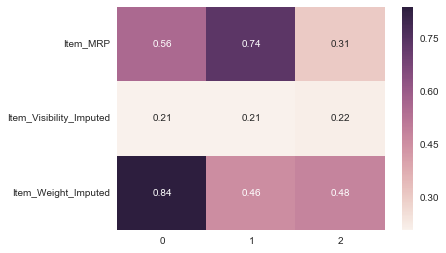

In [152]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.heatmap(cluster_summary[cluster_columns].transpose(), annot=True)

In [153]:
cluster_df['ClusterName'] = ''
cluster_df['ClusterName'][cluster_df['Cluster']==0] = 'Cluster-1'
cluster_df['ClusterName'][cluster_df['Cluster']==1] = 'Cluster-2'
cluster_df['ClusterName'][cluster_df['Cluster']==2] = 'Cluster-3'

In [154]:
cluster_df.head()

,Item_MRP,Item_Visibility_Imputed,Item_Weight_Imputed,Cluster,ClusterName
0,0.936006,0.048866,0.435597,1,Cluster-2
1,0.180859,0.058705,0.277283,2,Cluster-3
2,0.530626,0.051037,0.819672,0,Cluster-1
3,0.682289,0.054308,0.899297,0,Cluster-1
4,0.201812,0.029781,0.418267,2,Cluster-3


In [155]:
data = pd.concat([data,cluster_df['ClusterName']],axis=1)

** Features Set 8 - Distance & Coordinate Based Features **

In [156]:
# KNN or any distance based features
pass

** Features set 9: Encoding Categorical Features **

In [157]:
cat_enc_df = pd.DataFrame()

In [158]:
print(list(data.select_dtypes(include=['object']).columns))

['Item_Fat_Content', 'Item_Identifier', 'Item_Type', 'Outlet_Identifier', 'Outlet_Location_Type', 'Outlet_Size', 'Outlet_Type', 'source', 'Outlet_Size_Imputed', 'Outlet_Size_FillNA', 'Outlet_Size_NaN', 'Item_Weight_NaN', 'Item_Visibility_NaN', 'Item_Fat_Content_modified', 'Item_Type_Combined', 'PriceLevels', 'WeightLevels', 'VisibilityLevels', 'ClusterName']


In [159]:
# 1 - Selecting specific columns for label encoding
cat_cols_for_encoding = ['Outlet_Size_Imputed', 'Outlet_Size_FillNA', 'Outlet_Size_NaN', 'Item_Weight_NaN', 
                         'Item_Visibility_NaN', 'Item_Fat_Content_modified', 'Item_Type_Combined', 
                         'PriceLevels', 'WeightLevels', 'VisibilityLevels','ClusterName']

In [160]:
cat_pipe_1 = Pipeline([
                        ('extract_features',ExtractColumns(cat_cols_for_encoding)),
                        ('ordinal_enc',OrdinalEncoder()),
                         #('binary_enc',BinaryEncoder()),
                        #('dummy_enc',DummyTransformer()),
                     ])

In [161]:
cat_enc_df = cat_pipe_1.fit_transform(data)
cat_enc_df.rename(columns=lambda x: x + '_lb_enc', inplace=True)
cat_enc_df.head()

,Outlet_Size_Imputed_lb_enc,Outlet_Size_FillNA_lb_enc,Outlet_Size_NaN_lb_enc,Item_Weight_NaN_lb_enc,Item_Visibility_NaN_lb_enc,Item_Fat_Content_modified_lb_enc,Item_Type_Combined_lb_enc,PriceLevels_lb_enc,WeightLevels_lb_enc,VisibilityLevels_lb_enc,ClusterName_lb_enc
0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,1,1,1,0,1
2,0,0,0,0,0,0,0,2,2,0,2
3,1,1,1,0,1,1,0,3,3,0,2
4,2,2,0,0,1,2,2,1,0,0,1


In [162]:
# 2 - Frequency encoding of categorical features
cat_freq_enc_cols=['Item_Identifier','Outlet_Identifier','Outlet_Type']
train_freq_df = data[data['source']=='train'][cat_freq_enc_cols]
test_freq_df = data[data['source']=='test'][cat_freq_enc_cols]

# loop through each feature column to do this
for col in cat_freq_enc_cols:
    # capture the frequency of a feature in the training set
    col_freq=col+'_freq'
    freq=train_freq_df[col].value_counts()
    
    # Map the frequency to the appropriate column
    train_freq_df[col_freq] = train_freq_df[col].map(freq)
    test_freq_df[col_freq] = test_freq_df[col].map(freq)

    test_freq_df.fillna(0, inplace=True)
# generate dataframe for frequency features for the train and test dataset

cat_enc_feats = pd.concat([train_freq_df, test_freq_df],ignore_index=True)
cat_enc_feats = cat_enc_feats.iloc[:,len(cat_freq_enc_cols):]
cat_enc_feats.head()

,Item_Identifier_freq,Outlet_Identifier_freq,Outlet_Type_freq
0,8,930,5577
1,6,928,928
2,7,930,5577
3,6,555,1083
4,6,932,5577


In [163]:
cat_enc_df = pd.concat([cat_enc_df,cat_enc_feats],axis=1)

In [164]:
cat_enc_df.head()

,Outlet_Size_Imputed_lb_enc,Outlet_Size_FillNA_lb_enc,Outlet_Size_NaN_lb_enc,Item_Weight_NaN_lb_enc,Item_Visibility_NaN_lb_enc,Item_Fat_Content_modified_lb_enc,Item_Type_Combined_lb_enc,PriceLevels_lb_enc,WeightLevels_lb_enc,VisibilityLevels_lb_enc,ClusterName_lb_enc,Item_Identifier_freq,Outlet_Identifier_freq,Outlet_Type_freq
0,0,0,0,0,0,0,0,0,0,0,0,8,930,5577
1,0,0,0,0,0,1,1,1,1,0,1,6,928,928
2,0,0,0,0,0,0,0,2,2,0,2,7,930,5577
3,1,1,1,0,1,1,0,3,3,0,2,6,555,1083
4,2,2,0,0,1,2,2,1,0,0,1,6,932,5577


In [165]:
data = pd.concat([data,cat_enc_df],axis=1)

** Feature Set 10: Transformation of Numerical Features **

In [166]:
num_transform_df = pd.DataFrame()

In [167]:
# Take a look at the numerical columns
num_cols = list(data.select_dtypes(include=['float','int64']).columns)

In [168]:
#1 - Transformation of Numerical variables (ex: Scaler, Log Boxcox etc.)

# num_cols = num_feats_1.columns  # All numerical columns
# Selecting specific columns for encoding
num_cols_for_scaling = ['Item_MRP_clipped']
num_cols_for_tf = ['Item_Visibility_Imputed','Item_Weight_Imputed']

In [169]:
num_pipe_1 = Pipeline([
            ('extract_features',ExtractColumns(num_cols_for_scaling)),
            #('min_max_scaler',DFMinMaxScaler()),
             ('std_scaler',DFStandardScaler()),        
         ])

In [170]:
num_pipe_2 = Pipeline([
            ('extract_features',ExtractColumns(num_cols_for_tf)),
            ('log',DFFunctionTransformer(np.log1p)),
            #('sqrt',DFFunctionTransformer(np.sqrt))
         ])

In [171]:
num_feature_union = DFFeatureUnion([
                           ('pipe_1',num_pipe_1),
                           ('pipe_2',num_pipe_2),
                           ])
num_all_pipeline = Pipeline([('num_feats', num_feature_union)])
num_transform_df = num_all_pipeline.fit_transform(data)

In [172]:
num_transform_df.rename(columns=lambda x: x + '_tf', inplace=True)
num_transform_df.head()

,Item_MRP_clipped_tf,Item_Visibility_Imputed_tf,Item_Weight_Imputed_tf
0,1.754051,0.015920,2.332144
1,-1.494959,0.019095,1.934416
2,0.009910,0.016621,2.917771
3,0.662436,0.017677,3.005683
4,-1.404807,0.009732,2.295560


In [173]:
num_transform_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Item_MRP_clipped_tf,14204.0,-1.550748e-17,1.000035,-1.704278,-0.757543,0.020050,0.723061,1.962819
Item_Visibility_Imputed_tf,14204.0,6.634366e-02,0.045305,0.003568,0.030670,0.055618,0.092516,0.283968
Item_Weight_Imputed_tf,14204.0,2.562192e+00,0.361178,1.714698,2.273156,2.610070,2.876386,3.106826


In [174]:
data = pd.concat([data,num_transform_df],axis=1)

** Feature Set 11: Dimensionality Reduction based Features **

Explained Variance: %s [0.47710208 0.27413478 0.18572855]


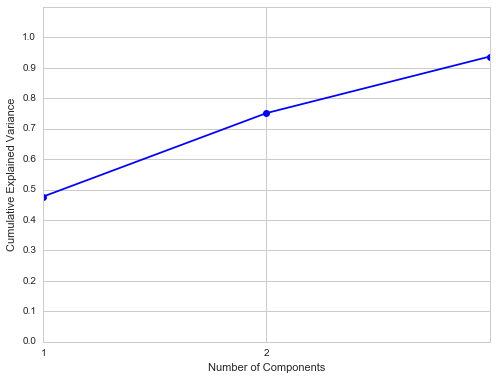

In [175]:
# Techniques - PCA, SVD, NMF & Factorization Machines

# PCA Implementation below
if 1==1:
    cols_for_dim_reduction = ['Outlet_Size_Imputed_lb_enc','Item_Fat_Content_modified_lb_enc','Item_Weight_Imputed_tf',
                              'Item_MRP_clipped_tf','Item_Visibility_Imputed_tf']
    
    # PCA
    n_components = 3
    pca = PCA(n_components=n_components)
    fit_pca = pca.fit(data[cols_for_dim_reduction])
    varExp = fit_pca.explained_variance_ratio_
    print("Explained Variance: %s",fit_pca.explained_variance_ratio_)
    #print(fit_pca.components_)
    pca_df_train = pd.DataFrame(fit_pca.transform(data[data['source']=='train'][cols_for_dim_reduction]))
    pca_df_test = pd.DataFrame(fit_pca.transform(data[data['source']=='test'][cols_for_dim_reduction]))
    
    cumVarExplained = []
    nb_components = []
    counter = 1
    for i in varExp:
        cumVarExplained.append(varExp[0:counter].sum())
        nb_components.append(counter)
        counter += 1

    plt.subplots(figsize=(8, 6))
    plt.plot(nb_components, cumVarExplained, 'bo-')
    plt.ylabel('Cumulative Explained Variance')
    plt.xlabel('Number of Components')
    plt.ylim([0.0, 1.1])
    plt.xticks(np.arange(1, len(nb_components), 1.0))
    plt.yticks(np.arange(0.0, 1.1, 0.10))

In [176]:
pca_df = pd.DataFrame()
pca_df = pd.concat([pca_df_train,pca_df_test])

pca_cols=[]
for i in range(n_components):
    new_col = 'pca' + '_' + str(i+1)
    pca_cols.append(new_col)
    
pca_df.columns = pca_cols
pca_df = pca_df[~pca_df.index.duplicated(keep='first')]

In [177]:
pca_df.head()

,pca_1,pca_2,pca_3
0,1.741497,-0.759029,-0.780953
1,-1.499466,0.274907,-0.781373
2,0.005386,-0.724442,-0.781842
3,0.671598,0.268986,0.217743
4,-1.392042,1.281675,1.217797


In [178]:
data = pd.concat([data,pca_df],axis=1,join_axes=[data.index])

### Logical Point to Separate Train & Test 

In [179]:
data.head()

,Item_Fat_Content,Item_Identifier,Item_MRP,Item_Outlet_Sales,Item_Type,Item_Visibility,Item_Weight,Outlet_Establishment_Year,Outlet_Identifier,Outlet_Location_Type,...,ClusterName_lb_enc,Item_Identifier_freq,Outlet_Identifier_freq,Outlet_Type_freq,Item_MRP_clipped_tf,Item_Visibility_Imputed_tf,Item_Weight_Imputed_tf,pca_1,pca_2,pca_3
0,Low Fat,FDA15,249.8092,3735.1380,Dairy,0.016047,9.30,1999,OUT049,Tier 1,...,0,8,930,5577,1.754051,0.015920,2.332144,1.741497,-0.759029,-0.780953
1,Regular,DRC01,48.2692,443.4228,Soft Drinks,0.019278,5.92,2009,OUT018,Tier 3,...,1,6,928,928,-1.494959,0.019095,1.934416,-1.499466,0.274907,-0.781373
2,Low Fat,FDN15,141.6180,2097.2700,Meat,0.016760,17.50,1999,OUT049,Tier 1,...,2,7,930,5577,0.009910,0.016621,2.917771,0.005386,-0.724442,-0.781842
3,Regular,FDX07,182.0950,732.3800,Fruits and Vegetables,0.000000,19.20,1998,OUT010,Tier 3,...,2,6,555,1083,0.662436,0.017677,3.005683,0.671598,0.268986,0.217743
4,Low Fat,NCD19,53.8614,994.7052,Household,0.000000,8.93,1987,OUT013,Tier 3,...,1,6,932,5577,-1.404807,0.009732,2.295560,-1.392042,1.281675,1.217797


In [180]:
train_feats = data[data['source']=='train']
test_feats = data[data['source']=='test']

In [181]:
print (train_feats.shape, test_feats.shape, data.shape)

(8523, 62) (5681, 62) (14204, 62)


In [182]:
%store train_feats
%store test_feats
%store target_df

Stored 'train_feats' (DataFrame)
Stored 'test_feats' (DataFrame)
Stored 'target_df' (DataFrame)
